# Ted Talks (Dataset with Transcripts)

From csv ted_talks_en.csv

URL:  https://www.kaggle.com/datasets/miguelcorraljr/ted-ultimate-dataset/data

Columns = 'talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations', 'about_speakers', 'views', 'recorded_date', 'published_date', 'event', 'native_lang', 'available_lang', 'comments', 'duration', 'topics', 'related_talks', 'url', 'description', 'transcript'.

# WHERE I LEFT OFF?!

Copied this Jupyter notebook from other my work on the other dataset.




In [13]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm

# !pip install watermark
# from watermark import watermark
# print(watermark(packages="numpy,pandas,matplotlib,seaborn,scipy,statsmodels"))

In [4]:
df = pd.read_csv("ted_talks_en.csv")
# SAVE TO CSV 


In [5]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 50

In [6]:
str(df.columns)

"Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',\n       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',\n       'native_lang', 'available_lang', 'comments', 'duration', 'topics',\n       'related_talks', 'url', 'description', 'transcript'],\n      dtype='object')"

In [7]:
df1 = df # copy the dataframe

In [8]:
df1.shape

(4005, 19)

In [10]:
df1.isna().sum()

title     0
author    1
date      0
views     0
likes     0
link      0
dtype: int64

In [10]:
# How many unique values are in each column?

for col in df1.columns:
    selected = df1[col]
    n_unique = selected.unique().shape[0]
    print(" Column {:40s} has {:6d} unique values".format(col,n_unique))

 Column talk_id                                  has   4005 unique values
 Column title                                    has   4005 unique values
 Column speaker_1                                has   3274 unique values
 Column all_speakers                             has   3307 unique values
 Column occupations                              has   2050 unique values
 Column about_speakers                           has   2978 unique values
 Column views                                    has   3996 unique values
 Column recorded_date                            has   1335 unique values
 Column published_date                           has   2962 unique values
 Column event                                    has    459 unique values
 Column native_lang                              has     12 unique values
 Column available_lang                           has   3902 unique values
 Column comments                                 has    602 unique values
 Column duration                      

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   talk_id         4005 non-null   int64  
 1   title           4005 non-null   object 
 2   speaker_1       4005 non-null   object 
 3   all_speakers    4001 non-null   object 
 4   occupations     3483 non-null   object 
 5   about_speakers  3502 non-null   object 
 6   views           4005 non-null   int64  
 7   recorded_date   4004 non-null   object 
 8   published_date  4005 non-null   object 
 9   event           4005 non-null   object 
 10  native_lang     4005 non-null   object 
 11  available_lang  4005 non-null   object 
 12  comments        3350 non-null   float64
 13  duration        4005 non-null   int64  
 14  topics          4005 non-null   object 
 15  related_talks   4005 non-null   object 
 16  url             4005 non-null   object 
 17  description     4005 non-null   o

In [19]:
# Assign new text to the 'transcript' column of row 579
df1.at[579, 'transcript'] = "Right now is the most exciting time to see new Indian art. Contemporary artists.... (Applause)"
df1.at[579, 'description'] = "Collector Ravin Agrawal delivers a glowing introduction to 10 of India's most exciting..."

# Now you can proceed with your existing code to display the row
row = df1.iloc[579]
markdown_table = row.to_frame().T.to_markdown(index=False)
print(markdown_table)


|   talk_id | title                            | speaker_1     | all_speakers         | occupations       | about_speakers                                                                                                                               |   views | recorded_date   | published_date   | event         | native_lang   | available_lang                                                                                                                                                  |   comments |   duration | topics                                       | related_talks                                                                                                                                                                                                                   | url                                                                       | description                                                                               | transcript                               

In [11]:
# Select the first row (you can change the row index as needed)
row = df1.iloc[579]

# Convert the row to markdown table format
markdown_table = row.to_frame().T.to_markdown(index=False)

# Print the markdown table
print(markdown_table)

|   talk_id | title                            | speaker_1     | all_speakers         | occupations       | about_speakers                                                                                                                               |   views | recorded_date   | published_date   | event         | native_lang   | available_lang                                                                                                                                                  |   comments |   duration | topics                                       | related_talks                                                                                                                                                                                                                   | url                                                                       | description                                                                                                                          

In [ ]:
# the most recent published date was 2022-10-13.  This information is used to determine when the last update of each video's view and likes was made.  
sorted_df_by_published_date = df1.sort_values(by='published_date', ascending=False)

In [18]:
# the most recent published date was 2022-10-13.  This information is used to determine when the last update of each video's view and likes was made.  
sorted_df_by_published_date = df1.sort_values(by='published_date', ascending=False)
sorted_df_by_published_date


,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
4004,62794,The most important anus in the ocean,Cella Wright,{0: 'Cella Wright'},NaN,NaN,0,2020-04-30,2020-04-30,TED-Ed,en,['en'],NaN,281,"['animals', 'TED-Ed', 'animation', 'oceans', '...","{62347: 'The bug that poops candy', 29159: 'In...",https://www.ted.com/talks/cella_wright_the_mos...,Is it a fuzzy sock? An overripe banana? A mold...,Can you guess what you’re looking at? Is it a ...
4003,62784,The electrifying speeches of Sojourner Truth,Daina Ramey Berry,{0: 'Daina Ramey Berry'},NaN,NaN,56582,2020-04-28,2020-04-30,TED-Ed,en,['en'],NaN,257,"['TED-Ed', 'education', 'animation', 'United S...",{20973: 'The breathtaking courage of Harriet T...,https://www.ted.com/talks/daina_ramey_berry_th...,Isabella Baumfree was born into slavery in lat...,"In early 1828, Sojourner Truth approached the ..."
4002,62263,"How ""policing for profit"" undermines your rights",Dick M. Carpenter II,{0: 'Dick M. Carpenter II'},{0: ['law researcher']},{0: 'Dick M. Carpenter II studies cutting edge...,464414,2019-06-22,2020-04-28,TEDxMileHigh,en,['en'],9.0,774,"['society', 'law', 'policy', 'justice system',...","{2406: 'I love being a police officer, but we ...",https://www.ted.com/talks/dick_m_carpenter_ii_...,"Many countries have an active, centuries-old l...",Picture yourself driving down the road tomorro...
4001,62782,The dark history of IQ tests,Stefan C Dombrowski,{0: 'Stefan C Dombrowski'},NaN,NaN,307187,2020-04-27,2020-04-27,TED-Ed,en,"['en', 'es', 'my', 'pt-br']",NaN,346,"['TED-Ed', 'education', 'history', 'animation'...",{35386: 'How does the Rorschach inkblot test w...,https://www.ted.com/talks/stefan_c_dombrowski_...,"In 1905, psychologists Alfred Binet and Théodo...","In 1905, psychologists Alfred Binet and Théodo..."
4000,62678,"Crisis support for the world, one text away",Nancy Lublin,{0: 'Nancy Lublin'},{0: ['health activist']},"{0: 'Nancy Lublin, cofounder and CEO of Crisis...",502934,2020-04-22,2020-04-27,TED2020: The Prequel,en,['en'],6.0,690,"['activism', 'data', 'technology', 'mental hea...",{2362: 'How data from a crisis text line is sa...,https://www.ted.com/talks/nancy_lublin_crisis_...,What if we could help people in crisis anytime...,"""I'm 14, and I want to go home."" ""My name is B..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,en,"['ar', 'bg', 'bn', 'ca', 'cs', 'de', 'en', 'es...",219.0,1116,"['MacArthur grant', 'activism', 'business', 'c...",{1041: '3 stories of local eco-entrepreneurshi...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'fa', 'fr...",124.0,1286,"['computers', 'entertainment', 'interface desi...","{1725: '10 top time-saving tech tips', 2274: '...",https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,en,"['ar', 'az', 'bg', 'bn', 'bs', 'cs', 'da', 'de...",628.0,1190,"['Africa', 'Asia', 'Google', 'demo', 'economic...","{2056: ""Own your body's data"", 2296: 'A visual...",https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 

In [6]:
# Select the first row (you can change the row index as needed)
row = df1.iloc[579]

# Convert the row to markdown table format
markdown_table = row.to_frame().T.to_markdown(index=False)

# Print the markdown table
print(markdown_table)

|   talk_id | title                      | speaker          | recorded_date   | published_date   | event          |   duration |   views |   likes |
|----------:|:---------------------------|:-----------------|:----------------|:-----------------|:---------------|-----------:|--------:|--------:|
|       723 | My solar-powered adventure | Bertrand Piccard | 2009-07-24      | 2010-01-01       | TEDGlobal 2009 |       1049 |  903784 |   27000 |


In [8]:
df1["event"].nunique

<bound method IndexOpsMixin.nunique of 0                              TED2006
1                              TED2006
2                              TED2006
3                              TED2006
4                              TED2006
                     ...              
5696                            TED-Ed
5697          TED Salon Bezos Scholars
5698    Body Stuff with Dr. Jen Gunter
5699                            TED-Ed
5700                        TEDxSurrey
Name: event, Length: 5701, dtype: object>

In [12]:
#Changing DateTime columns to DateTime

df1["date"] = pd.to_datetime(df1["date"])

/var/folders/l2/d5ln4l29453322fq40g1dz2h0000gn/T/ipykernel_72805/4165279598.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1["date"] = pd.to_datetime(df1["date"])


In [180]:
df1["event"].value_counts()

event
TED-Ed               890
TED2018              104
TED2020              102
TED2019              101
TED2017               97
                    ... 
TEDxEastEnd            1
TEDActive 2015         1
Global Witness         1
TEDxCreativeCoast      1
TEDxSurrey             1
Name: count, Length: 637, dtype: int64

## Null Imputing

In [39]:
# Null Imputing = the only two nulls here are from 2020 events.  I am going to impute them with '2020-07-24' (see next block of code), which is a day that TED 2020 was hosted on.
rows_with_null_as_recorded_date = df1[df1["recorded_date"].isna()]
rows_with_null_as_recorded_date

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes


In [36]:
# imputing nulls - Adding the recorded_date to the Debbie Millman speech.  This event was over a 1.5 month long period in 2020, which included the published date (the date I'm using to impute)
df1.loc[df1['talk_id'] == 65384, 'recorded_date'] = '2020-07-24'

In [38]:
# I'm imputing e Bearutyrest missing recorded date with it's published date.
df1.loc[df1['talk_id'] == 65233, 'recorded_date'] = '2020-07-29'

In [59]:
# I'm dropping the other nulls as they represent too few datapoints (2 out of 5701)
df1.dropna(inplace=True)
df1.info()

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes,published_year,published_month,recorded_year,recorded_month,percent_likes
5606,94839,"How ""dilemma thinking"" transforms argument int...",Countdown,2022-06-16,2022-07-08,NaN,223,14028,420,2022,7,2022,6,2.994012


There are no more null values in the dataset.

In [75]:
df1.isna().sum()

talk_id            0
title              0
speaker            0
recorded_date      0
published_date     0
event              0
duration           0
views              0
likes              0
published_year     0
published_month    0
recorded_year      0
recorded_month     0
percent_likes      0
dtype: int64

In [128]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5699 entries, 0 to 5700
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   talk_id          5699 non-null   int64         
 1   title            5699 non-null   object        
 2   speaker          5699 non-null   object        
 3   recorded_date    5699 non-null   datetime64[ns]
 4   published_date   5699 non-null   datetime64[ns]
 5   event            5699 non-null   object        
 6   duration         5699 non-null   int64         
 7   views            5699 non-null   int64         
 8   likes            5699 non-null   int64         
 9   published_year   5699 non-null   int32         
 10  published_month  5699 non-null   int32         
 11  recorded_year    5699 non-null   int32         
 12  recorded_month   5699 non-null   int32         
 13  percent_likes    5699 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int32(4), i

## Creating Additional Columns:

- published_year
- published_month
- recorded_year
- recorded_month
- percent_likes

In [42]:
# Creating a "published_year" "published_month" "recorded_date" and "recorded_month" columns

df1["published_year"] = df1["published_date"].dt.year
df1["published_month"] = df1["published_date"].dt.month
df1["recorded_year"] = df1["recorded_date"].dt.year
df1["recorded_month"] = df1["recorded_date"].dt.month

In [43]:
# Creating a "percent_likes" column

df1["percent_likes"] = (df1["likes"] / df1["views"]) * 100
df1

,talk_id,title,speaker,recorded_date,published_date,event,duration,views,likes,published_year,published_month,recorded_year,recorded_month,percent_likes
0,1,Averting the climate crisis,Al Gore,2006-02-25,2006-06-27,TED2006,957,3681537,110000,2006,6,2006,2,2.987883
1,7,Simplicity sells,David Pogue,2006-02-24,2006-06-27,TED2006,1266,2012797,60000,2006,6,2006,2,2.980927
2,53,Greening the ghetto,Majora Carter,2006-02-26,2006-06-27,TED2006,1096,3006315,90000,2006,6,2006,2,2.993698
3,92,The best stats you've ever seen,Hans Rosling,2006-02-22,2006-06-27,TED2006,1176,15432904,462000,2006,6,2006,2,2.993604
4,66,Do schools kill creativity?,Sir Ken Robinson,2006-02-25,2006-06-27,TED2006,1151,73935964,2200000,2006,6,2006,2,2.975548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5696,98707,Is inequality inevitable?,TED-Ed,2022-10-11,2022-10-11,TED-Ed,390,109948,3200,2022,10,2022,10,2.910467
5697,98662,4 ways to design a disability-friendly future,Meghan Hussey,2022-09-08,2022-10-11,TED Salon Bezos Scholars,544,310241,9300,2022,10,2022,9,2.997670
5698,98383,"Can exercise actually ""boost"" your metabolism?",Jen Gunter,2022-10-12,2022-10-12,Body Stuff with Dr. Jen Gunter,210,30087,902,2022,10,2022,10,2.997973
5699,98706,How did they build the Great Pyramid of Giza?,Soraya Field Fiorio,2022-10-13,2022-10-13,TED-Ed,332,456,13,2022,10,2022,10,2.850877


In [ ]:
How are VIEWS Distributed across:
- Year published
- Year recorded
- Month Published
- Month recorded
- Event 

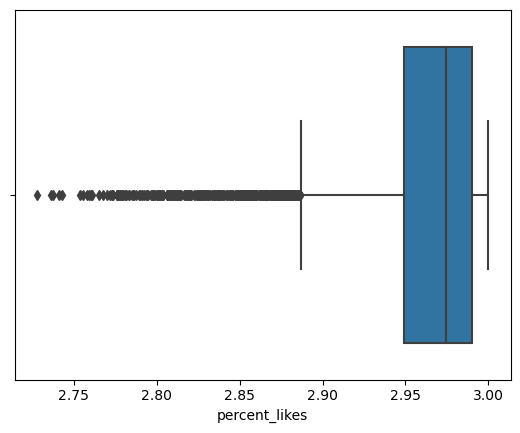

In [129]:
# the percent of "likes" is heavily distributed towards 3%, 

sns.boxplot(data=df1, x="percent_likes")
plt.show()

## Most percent_likes are close to 3%

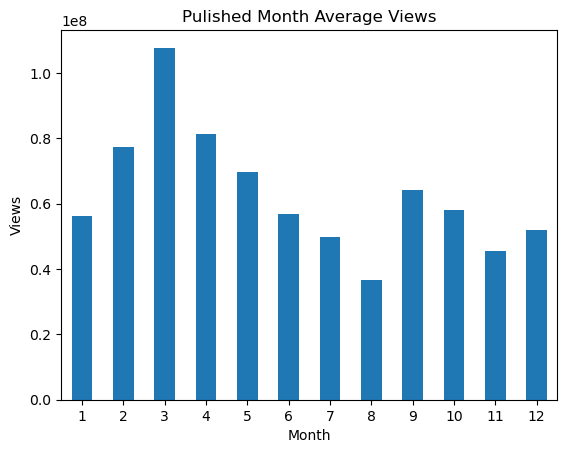

In [126]:
# Monthly average of views by publishing month

monthly_average_pub = df1.groupby(["published_year", "published_month"])["views"].sum()
cross_year_average_pub = monthly_average_pub.groupby("published_month").mean()
cross_year_average_pub
cross_year_average_pub.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Views')
plt.title('Pulished Month, Average Views')
plt.xticks(rotation=0)
plt.show()

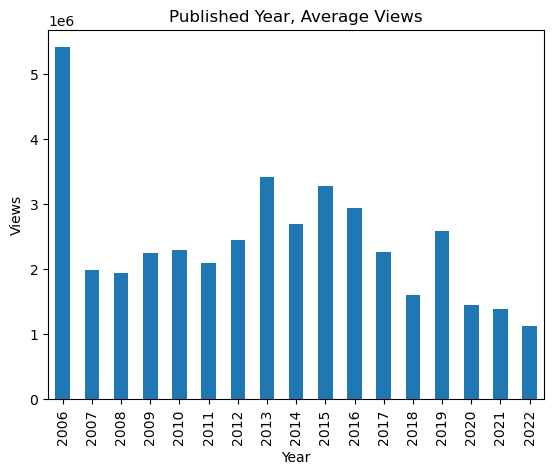

In [127]:
# Yearly average of views by publishing year

yearly_average_pub = df1.groupby(["published_year"])["views"].mean()
yearly_average_pub.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Views')
plt.title('Published Year, Average Views')
plt.xticks(rotation=90)
plt.show()


<Axes: xlabel='recorded_month'>

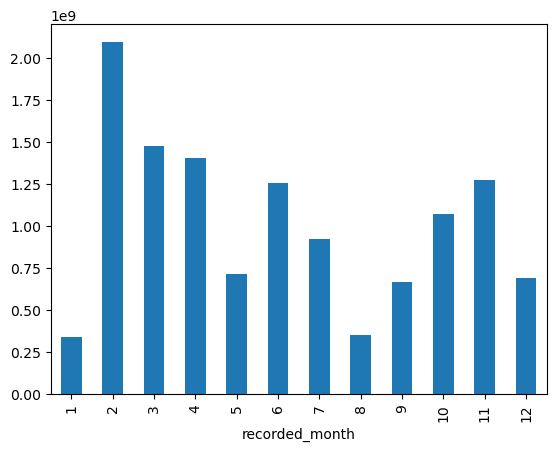

In [114]:
monthly_average_rec = df1.groupby(["recorded_year", "recorded_month"])["views"].sum()

cross_year_average_rec = monthly_average_rec.groupby("recorded_month").sum()

cross_year_average_rec

cross_year_average_rec.plot(kind='bar')

In [194]:
df.groupby("published_year")["views"].sum()

published_year
2006     265293948
2007     241842093
2008     359815610
2009     499541914
2010     582502031
2011     545416070
2012     750886270
2013     832134679
2014     641978957
2015     721912392
2016     703522313
2017     856363822
2018    1149973664
2019    2135894863
2020     956718652
2021     639095884
2022     357855515
Name: views, dtype: int64

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5701 entries, 0 to 5700
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   talk_id          5701 non-null   int64         
 1   title            5701 non-null   object        
 2   speaker          5700 non-null   object        
 3   recorded_date    5701 non-null   datetime64[ns]
 4   published_date   5701 non-null   datetime64[ns]
 5   event            5700 non-null   object        
 6   duration         5701 non-null   int64         
 7   views            5701 non-null   int64         
 8   likes            5701 non-null   int64         
 9   published_year   5701 non-null   int32         
 10  published_month  5701 non-null   int32         
 11  recorded_year    5701 non-null   int32         
 12  recorded_month   5701 non-null   int32         
 13  percent_likes    5701 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int32(

/Users/drewe/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


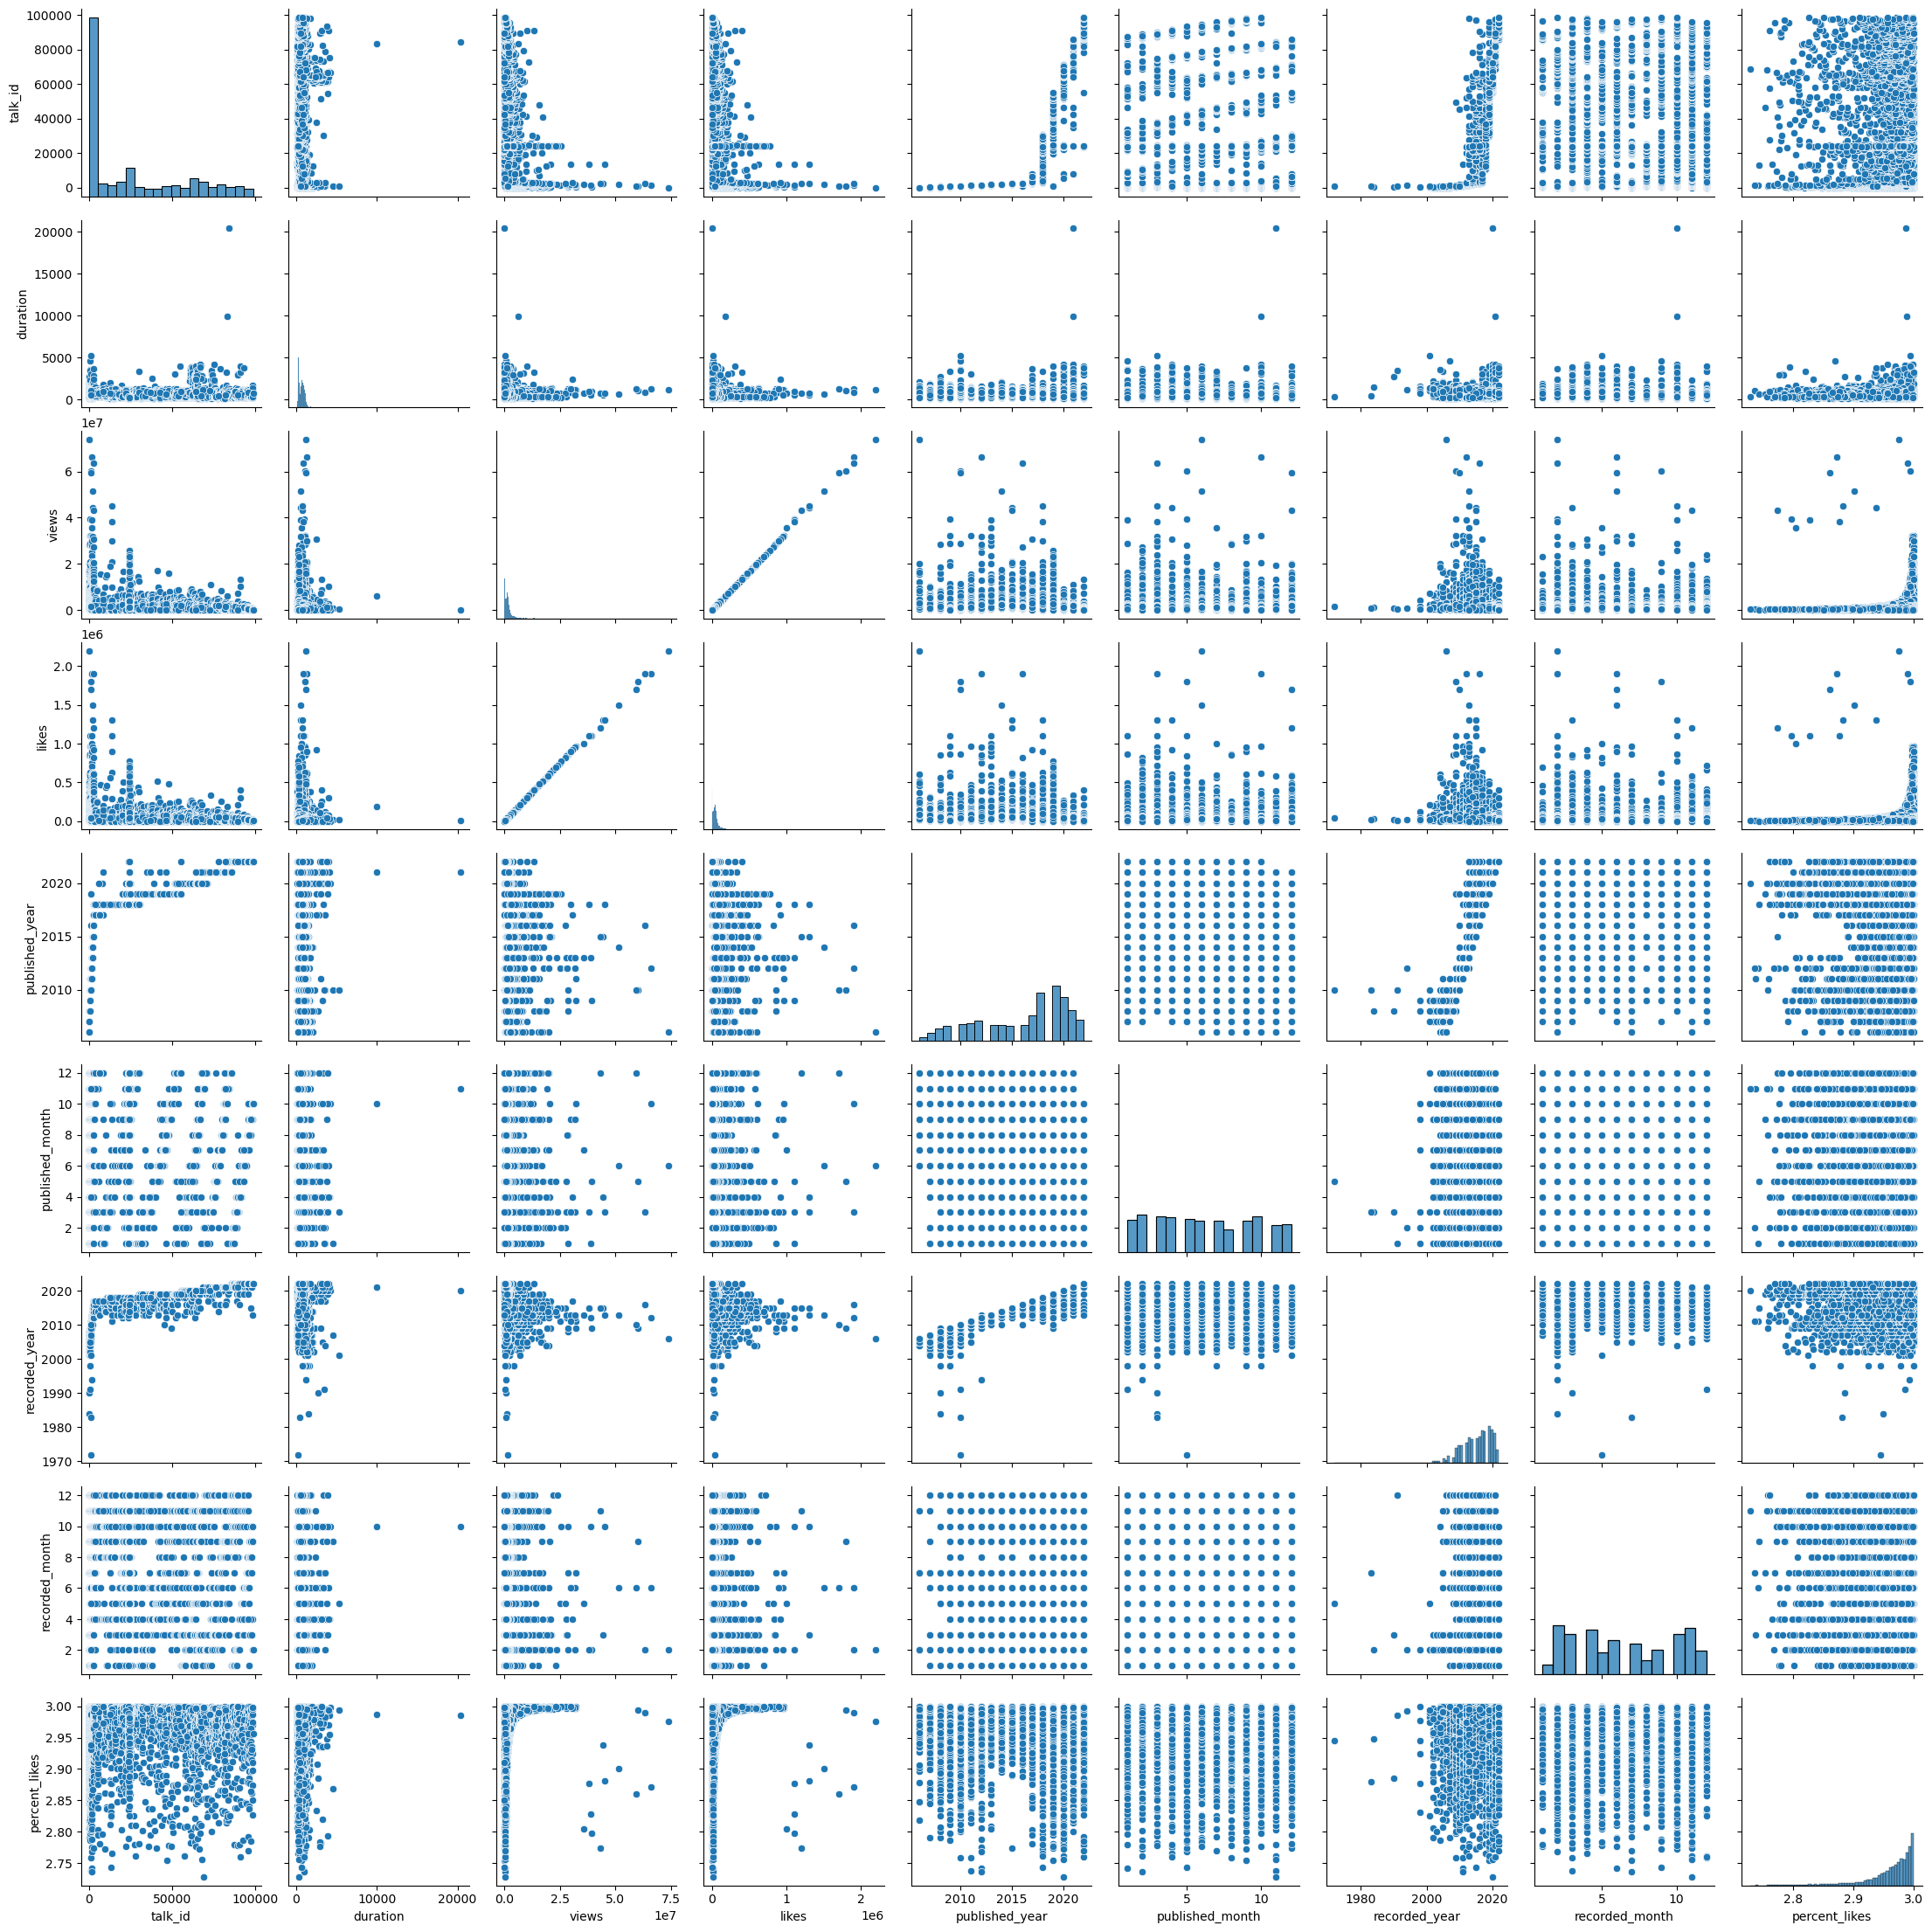

In [77]:
sns.pairplot(data=df1)
plt.show()

<Axes: >

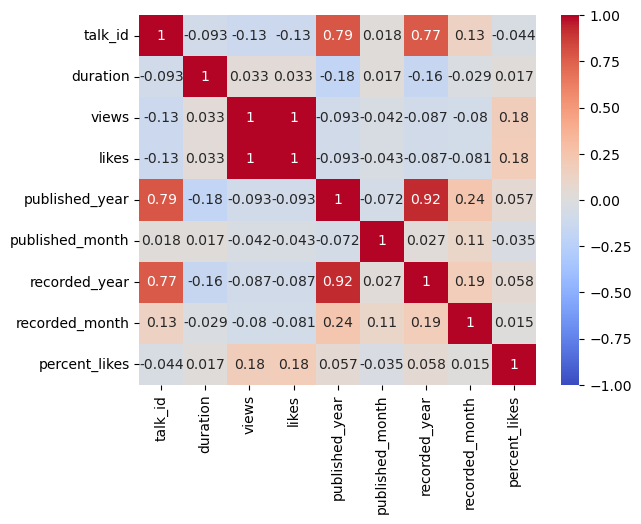

In [85]:
numerical = df1.select_dtypes("number")
sns.heatmap(numerical.corr(),vmin=-1.0,vmax=1.0,cmap='coolwarm',annot=True)

In [198]:
df1.groupby("recorded_year")["views"].mean()

recorded_year
1972    1.392109e+06
1983    6.944140e+05
1984    1.119188e+06
1990    7.280170e+05
1991    3.282550e+05
1994    7.016550e+05
1998    1.324330e+06
2001    2.148505e+06
2002    1.205708e+06
2003    1.650623e+06
2004    3.528891e+06
2005    2.513214e+06
2006    3.797227e+06
2007    1.604593e+06
2008    2.565590e+06
2009    2.481910e+06
2010    2.046966e+06
2011    2.204250e+06
2012    2.765764e+06
2013    2.861112e+06
2014    2.423039e+06
2015    3.273805e+06
2016    2.474413e+06
2017    2.163944e+06
2018    1.820584e+06
2019    1.859145e+06
2020    1.380717e+06
2021    1.402322e+06
2022    1.007166e+06
Name: views, dtype: float64

<Axes: xlabel='views', ylabel='recorded_year'>

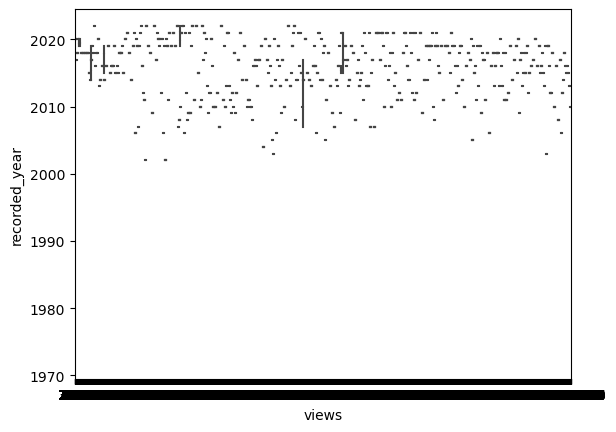

In [202]:
sns.boxplot(x="views", y="recorded_year", data=df1)

In [204]:
# General Correlation Table

df.corr(numeric_only=True)

,talk_id,duration,views,likes,published_year,published_month,recorded_year,recorded_month,percent_likes
talk_id,1.000000,-0.092871,-0.131383,-0.132124,0.787683,0.017785,0.769956,0.133080,-0.043286
duration,-0.092871,1.000000,0.033264,0.033365,-0.181504,0.016504,-0.161523,-0.028893,0.016403
views,-0.131383,0.033264,1.000000,0.999745,-0.092708,-0.042535,-0.087418,-0.080491,0.176993
likes,-0.132124,0.033365,0.999745,1.000000,-0.092811,-0.043352,-0.087611,-0.081260,0.183787
published_year,0.787683,-0.181504,-0.092708,-0.092811,1.000000,-0.071727,0.924854,0.236843,0.057040
published_month,0.017785,0.016504,-0.042535,-0.043352,-0.071727,1.000000,0.027398,0.107913,-0.034605
recorded_year,0.769956,-0.161523,-0.087418,-0.087611,0.924854,0.027398,1.000000,0.186159,0.057813
recorded_month,0.133080,-0.028893,-0.080491,-0.081260,0.236843,0.107913,0.186159,1.000000,0.015224
percent_likes,-0.043286,0.016403,0.176993,0.183787,0.057040,-0.034605,0.057813,0.015224,1.000000


#### Interesting Findings:

percent-likes correlations:
- Views: .176
- Likes: .183

recorded-month:


In [ ]:
# How many talks were there each year?

